As an introduction to tensorflow, let's use tensorflow to classify MNIST numerals. However, we will not be using keras -- while keras simplifies constructing basic neural networks, it decreases flexibility that we may need in the future (e.g., when we try to model optical processes). I will try keep this introduction as simple as possible without including too many extra features that, while likely to be useful, may distract you from getting something running for the first time. Once we get the basics down, in the future we can revisit some of the helpful tools, such as graph visualization and tensorboard.

# import data

In [28]:
import os
import glob
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def read_feature(folder, num):
    filename = glob.glob(os.path.join(folder, '*'))
    img_arr = np.zeros([len(filename), 100, 100, 3])
    label = num * np.ones(len(filename), dtype="float32")
    for i, name in enumerate(filename):
        img = Image.open(name)
        img_arr[i, :, :, :] = np.asarray(img, dtype="uint8")
    return img_arr, label


(4125, 100, 100, 3)
(4125,)
Training data shape (3712, 100, 100, 3)


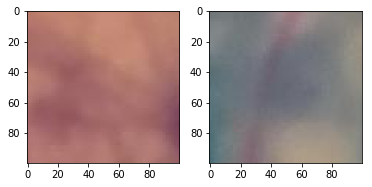

In [29]:
tb_img_arr, tb_label = read_feature('./TB_Image', 1)
non_tb_img_arr, non_tb_label = read_feature('./Non-TB_Image', 0)
images = np.concatenate((tb_img_arr, non_tb_img_arr))
labels = np.concatenate((tb_label, non_tb_label))

print(np.shape(images))
print(np.shape(labels))
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.1)

X_train = X_train.astype(np.int)
X_val = X_val.astype(np.int)
y_train = y_train.astype(np.int)
y_val = y_val.astype(np.int)

# change into one-hot vector
y_train = tf.keras.utils.to_categorical(y_train, 2) 
y_val = tf.keras.utils.to_categorical(y_val, 2)

# reshape dataset
X_train = X_train.reshape(X_train.shape[0], 100, 100, 3)
X_val = X_val.reshape(X_val.shape[0], 100, 100, 3)

from matplotlib import pyplot as plt
%matplotlib inline

print('Training data shape', X_train.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train[0].reshape(100, 100, 3), cmap=plt.cm.Greys);
ax2.imshow(X_train[1].reshape(100, 100, 3), cmap=plt.cm.Greys);



[[[103 102 107]
  [103 102 107]
  [103 103 105]
  ...
  [129 100 118]
  [130 101 119]
  [131 102 120]]

 [[103 102 107]
  [103 102 107]
  [103 103 105]
  ...
  [128  99 117]
  [129 100 118]
  [130 101 119]]

 [[104 103 108]
  [104 103 108]
  [104 104 106]
  ...
  [128  97 115]
  [129  98 116]
  [130  99 117]]

 ...

 [[119 119 119]
  [119 119 119]
  [120 120 120]
  ...
  [162 149 133]
  [161 148 132]
  [159 146 130]]

 [[119 119 119]
  [120 120 120]
  [121 121 121]
  ...
  [162 149 133]
  [160 147 131]
  [159 146 130]]

 [[120 120 120]
  [120 120 120]
  [121 121 121]
  ...
  [161 148 132]
  [160 147 131]
  [159 146 130]]]


In [12]:
def train_data(model, loss, val_loss):
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3)
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format('model_name'))
    hist = model.fit(X_train, y_train,
                     batch_size=64,
                     epochs=100,  # Run thru all the data point in each epoch
                     verbose=1,
                     validation_data=(X_val, y_val),
                     callbacks=[early_stop, tensorboard])
    #val_err.append(hist.history['val_mean_absolute_error'][-1]) # a dict
    loss.append(hist.history['loss'][-1])
    val_loss.append(hist.history['val_loss'][-1])
    
    
    return loss, val_loss, hist

In [19]:
# Example CNN used in class
def VGG_cifar100():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(100, 100, 3)),
        tf.keras.layers.MaxPool2D(padding='same'),

        tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(padding='same'),
        
        tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'),
        tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(padding='same'),
        
        tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu'),
        tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(padding='same'),

        tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu'),
        tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(padding='same'),


        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dense(1000, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    param = model.count_params()
    model.compile(optimizer=tf.train.AdamOptimizer(0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
   

    model.summary()
    
    return model, param

In [20]:
loss1 = []
val_loss1 =[]
param1 = []
activ = 'relu'
for i in range(0, 26, 5):
    print(i)
    model, param1 = VGG_cifar100()
    loss1, val_loss1, hist1= train_data(model, loss1, val_loss1)

0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 100, 100, 64)      1792      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 50, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 25, 25, 256)       295168    
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 25, 25, 256)       590080    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 13, 256)       0         
________

KeyboardInterrupt: 